# New Predictions for Combined Cycle Gas Turbine Generations


In [ ]:
import datetime
today = datetime.datetime.today().strftime('%Y-%m-%d')
one_month = (datetime.datetime.today() - datetime.timedelta(30)).strftime('%Y-%m-%d')
!curl -o data.csv "https://www.bmreports.com/bmrs/?q=ajax/filter_csv_download/FUELHH/csv/FromDate%3D{one_month}%26ToDate%3D{today}/&filename=GenerationbyFuelType_20191002_1657" 2>/dev/null


In [1]:
%matplotlib inline
import pandas as pd
import datetime

In [2]:
df = pd.read_csv('data.csv', skiprows=1, skipfooter=1, header=None, engine='python')


In [3]:
df.columns = ['HDF', 'date', 'half_hour_increment',
              'CCGT', 'OIL', 'COAL', 'NUCLEAR',
              'WIND', 'PS', 'NPSHYD', 'OCGT',
              'OTHER', 'INTFR', 'INTIRL', 'INTNED',
               'INTEW', 'BIOMASS', 'INTEM','INTEL',
               'INTIFA2', 'INTNSL']
df.head()


,HDF,date,half_hour_increment,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,...,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM,INTEL,INTIFA2,INTNSL
0,FUELHH,20200101,1,7912,0,670,6953,5004,0,672,...,130,1704,0,854,0,2353,854,0,0,0
1,FUELHH,20200101,2,8420,0,670,6949,5043,0,669,...,123,1704,0,852,0,2358,854,0,0,0
2,FUELHH,20200101,3,8037,0,670,6952,5030,0,662,...,122,1704,0,852,0,2356,854,0,0,0
3,FUELHH,20200101,4,7499,0,670,6948,4825,0,591,...,122,1704,0,852,0,2343,854,0,0,0
4,FUELHH,20200101,5,7020,0,669,6954,4689,0,548,...,121,1704,0,852,0,2356,854,0,0,0


In [4]:
df['datetime'] = pd.to_datetime(df['date'], format="%Y%m%d")
df['datetime'] = df.apply(lambda x:x['datetime']+ datetime.timedelta(minutes=30*(int(x['half_hour_increment'])-1)), axis = 1)


<AxesSubplot:xlabel='datetime'>

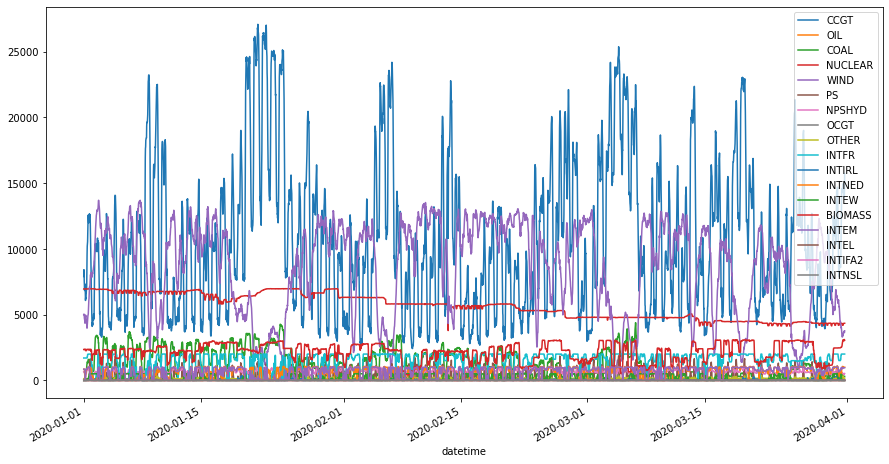

In [5]:
df.drop(
    ['HDF', 'date', 'half_hour_increment'], axis = 1
    ).set_index('datetime').plot(figsize=(15,8))


In [6]:
!pip install --user "convertdate" "holidays" "lunarcalendar" "cython==0.29.30" "numpy"
!pip install --user "pystan==2.19.1.1" 
!pip install --user "prophet"


  Using cached prophet-1.0.1.tar.gz (65 kB)
  Using cached cmdstanpy-0.9.68-py3-none-any.whl (49 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached ujson-5.3.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45 kB)
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=719797 sha256=b8a71ebca634f67f76c061f22a9fcde58191071a8b6165227d0b5b721046c5dd
  Stored in directory: /home/ubuntu/.cache/pip/wheels/26/0b/d9/6583b6a639c0ff50333d558826d4366c7739bd6a7450b80fec
Successfully built prophet


In [7]:
df_for_prophet = df[['datetime', 'CCGT']].rename(columns = {'datetime':'ds', 'CCGT':'y'})


In [8]:
X = df_for_prophet.copy()
y = df_for_prophet['y']
proportion_in_training = 0.8
split_index = int(proportion_in_training*len(y))
X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]
X_test, y_test = X.iloc[split_index:], y.iloc[split_index:]


In [9]:
from prophet import Prophet
m = Prophet()
m.fit(X_train)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/home/ubuntu/.local/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -138.854


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5051.32     0.0439418       251.041           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5124.02     0.0267518       133.032           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5132.95    0.00400051       109.473      0.9128      0.9128      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       5137.68   0.000591899       198.068   1.822e-06       0.001      419  LS failed, Hessian reset 
     396       5141.01   0.000190898       86.2224   1.739e-06       0.001      551  LS failed, Hessian reset 
     399       5141.01   3.07697e-05       74.9641      0.4784      0.4784      554   
    Iter      log prob        ||dx||      ||grad||       alpha

In [10]:
future = m.make_future_dataframe(periods=int(len(y_test)/2), freq='H')
forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() #uncomment to inspect the DataFrame


/home/ubuntu/.local/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ubuntu/.local/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


<Figure size 432x288 with 0 Axes>

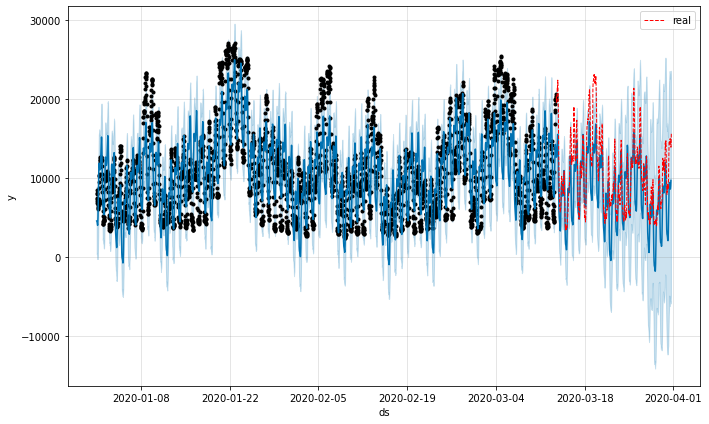

In [11]:
import matplotlib.pyplot as plt
plt.gcf()
fig = m.plot(forecast)
plt.plot(X_test['ds'].dt.to_pydatetime(), X_test['y'], 'r', linewidth = 1, linestyle = '--', label = 'real')
plt.legend()


In [12]:
import pickle
# m.stan_backend.logger = None    #uncomment if using Python 3.6 and fbprophet==0.6
with open("model.pkl", "wb") as f:
      pickle.dump(m, f)
